# Keyword to anchor text correlation study
- AHREFS interview assignment Q1
- (c) Adarsh Janakiraman
- Sept 2017

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import operator
import common_funcs as com
%matplotlib inline
import sys
reload(sys)
sys.setdefaultencoding('utf8')

In [2]:
# Read the pickles
df_toppages = pd.read_pickle('backlinko_toppages.pkl')
df_backlinks = pd.read_pickle('backlinko_backlinks.pkl')

In [3]:
df_joined = pd.merge(df_toppages, df_backlinks[['toppage_url','anchor']], left_on='URL',right_on='toppage_url')
df_joined.drop_duplicates(inplace=True)

In [5]:
keyword_tokens = com.get_tokens_from_terms(df_toppages.Keyword.tolist())
anchor_tokens = com.get_tokens_from_terms(df_backlinks.anchor.tolist())

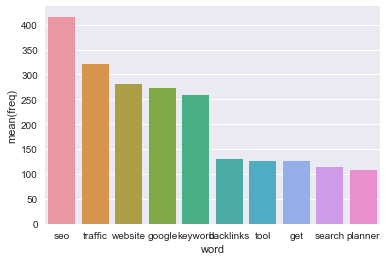

In [6]:
tmp1 = pd.DataFrame(com.get_top_n_tokens(anchor_tokens, 100), columns=['word','freq'])
tmp2 = pd.DataFrame(com.get_top_n_tokens(keyword_tokens, 10), columns=['word','freq'])
sns.barplot('word','freq',data=tmp2)

In [7]:
def counter_cosine_similarity(c1, c2):
    import math
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

In [9]:
tmp1 = com.get_top_n_tokens(anchor_tokens, 1000)
tmp2 = com.get_top_n_tokens(keyword_tokens, 1000)
counter_cosine_similarity(dict(tmp2), dict(tmp1))

0.4508547302777198

In [10]:
df_keywords = df_joined[['Keyword','anchor','Position']].copy()
df_keywords['Keyword'] = df_keywords['Keyword'].apply(lambda x: com.remove_stopwords(com.remove_punctuations(string.lower(x))))
df_keywords['anchor'] = df_keywords['anchor'].apply(lambda x: com.remove_stopwords(com.remove_punctuations(string.lower(x))))
df_keywords.head()

Keyword                                        anchor  Position
0  website traffic                                                       6
3  website traffic                          one thing struggling         6
6  website traffic                                   web traffic         6
7  website traffic        httpbacklinkocomsecretto119000visitors         6
9  website traffic  want increase website traffic follow 4 steps         6

In [11]:
df_keywords['exact_match'] = (df_keywords['Keyword'] == df_keywords['anchor']).astype(int)
df_keywords['phrase_match'] = df_keywords.apply(lambda row: com.phrase_match(row['Keyword'],row['anchor']), axis=1)
df_keywords.head()

Keyword                                        anchor  Position  \
0  website traffic                                                       6   
3  website traffic                          one thing struggling         6   
6  website traffic                                   web traffic         6   
7  website traffic        httpbacklinkocomsecretto119000visitors         6   
9  website traffic  want increase website traffic follow 4 steps         6   

   exact_match  phrase_match  
0            0             0  
3            0             0  
6            0             1  
7            0             0  
9            0             1

In [12]:
sns.set_style('ticks')
sns.boxplot('exact_match','Position',data=df_keywords)
plt.xlabel('Exact match')
plt.ylabel('Google search rank')
plt.title('Exact match (Keyword-Anchor) vs. Google search rank')
sns.despine()

In [13]:
sns.set_style('ticks')
sns.boxplot('phrase_match','Position',data=df_keywords)
plt.xlabel('Phrase match')
plt.ylabel('Google search rank')
plt.title('Phrase match (atleast one) vs. Google search rank')
sns.despine()

In [15]:
def build_regplots(df, col, colname, aggfunc='mean', save_file_name = ''):
    import scipy
    tmp = (df.groupby(['Position'])[col].agg(aggfunc)*100)
    x_vals = tmp.index.values
    y_vals = tmp
    slope, intercept, r_value, p_value, std_err \
                = scipy.stats.linregress(x=x_vals ,y=y_vals)
    r_squared = r_value**2
    sns.regplot(tmp.index.values, tmp)
    sns.despine()
    plt.xticks(range(0,11,1))
    plt.ylabel(colname)
    plt.xlabel('Google search rank')
    plt.title('Y = {0} - {1}x ; $R^2$ = {2}'.format(round(intercept,2), abs(round(slope,2)), round(r_squared,3)))
    if save_file_name:
        plt.savefig(save_file_name)
    plt.show();

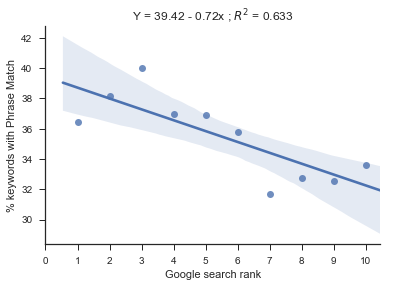

In [16]:
build_regplots(df_keywords, 'phrase_match','% keywords with Phrase Match', save_file_name = 'figs/anchor_phrase_match_full.png')

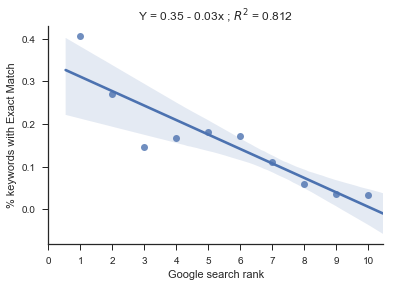

In [17]:
build_regplots(df_keywords, 'exact_match','% keywords with Exact Match', save_file_name = 'figs/anchor_exact_match_full.png')

In [20]:
df_keywords['anchor_brand'] = df_keywords.anchor.str.contains('backlinko').astype(int)

In [19]:
df_keywords['keyword_missing'] = 1-df_keywords[['exact_match','phrase_match']].apply(max, axis=1)
df_keywords['keyword_missing_w_anchor'] = 1-df_keywords[['exact_match','phrase_match']].apply(max, axis=1)

In [21]:
sns.distplot((df_keywords.groupby(['Keyword'])['keyword_missing'].mean()), kde=False, axlabel='% anchor text missing Keywords')
plt.ylabel('Frequency')
plt.title('Histogram of % of anchor text missing keywords')
plt.savefig('figs/keyword_missing_anchor_text.png')
plt.show()

In [22]:
build_regplots(df_keywords, 'keyword_missing','% keywords missing from anchor text', save_file_name='figs/anchor_keyword_missing_full.png')

In [23]:
df_keywords['anchor_text_length'] = df_keywords['anchor'].apply(lambda x: len(x.split()))
df_keywords['keyword_text_length'] = df_keywords['Keyword'].apply(lambda x: len(x.split()))

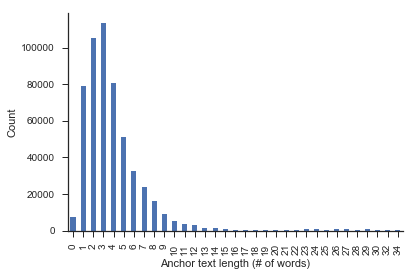

In [24]:
df_keywords.groupby(['anchor_text_length']).size().plot('bar')
sns.despine()
plt.xlabel('Anchor text length (# of words)')
plt.ylabel('Count')
plt.savefig('figs/anchor_text_length_dist.png')

In [25]:
df_keywords.to_pickle('keywords_anchor_q1.pkl')